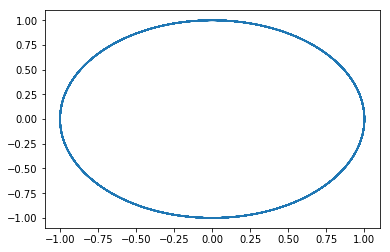

In [2]:
import matplotlib.pyplot as plt

dt = 0.0001
x = 1; y = 0

activate = []
deactivate = []

for ii in range(1000000):
    x = x + -y*dt
    y = y + x*dt
    activate.append(x)
    deactivate.append(y)
plt.plot(activate, deactivate)
plt.show()

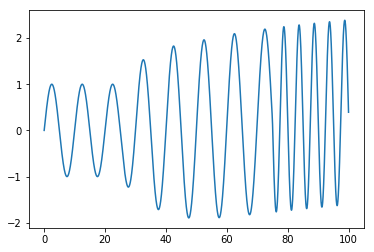

In [6]:

import math
import matplotlib.pyplot as plt
import numpy as np

amp = 1
camp = 0.1
phase = 0
offset = 0
coff = 0.01
frequency = 0.1
dt = 0.0001
time = np.arange(0,100,dt)
iterations = 1000000

def dp(frequency):
    return 2 * 3.141596 * frequency

def da(amp_target):
    return camp * (amp_target - amp)

def do(offset_target):
    return coff * (offset_target - offset)

def output():
    return amp * math.sin(phase) + offset

def update_values(amp_target = 1, offset_target = 0, frequency_target = 0.1):
    global phase, amp, offset
    phase = phase + dp(frequency_target) * dt
    amp = amp + da(amp_target) * dt
    offset = offset + do(offset_target) * dt

outputs = []

# showing off how cpgs can smoothly transition between states when 
# you change their parameters
for i in range(iterations):
    if i < iterations/4:
        update_values()
    elif i < iterations/4 * 2:
        update_values(2, 0)
    elif i < iterations/4 *3:
        update_values(2,1)
    else:
        update_values(2,1,0.2)
    outputs.append(output())

plt.plot(time, outputs)
plt.show()

The below will show two oscillatory patterns that work in or out of phase with each other. Again, parameter transition is smooth. 

See: https://www.youtube.com/watch?v=hZgxlShnTH4&t=458s

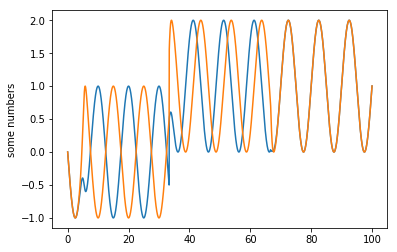

In [7]:
import math
import numpy as np

pi = 3.141569
amp = 1
camp = 0.8
phase = [pi, -pi]
offset = np.array([0,0])
coff = 0.01
frequency = 0.1
dt = 0.0001
result = 0

iterations = 1000000

def dp(frequency, idx, phase, phase_offset_target):
    if idx == 0:
        return 2 * pi * frequency + 1 * amp * math.sin(phase[1]-phase[0]-phase_offset_target)
    else:
        return 2 * pi * frequency + 1 * amp * math.sin(phase[0]-phase[1]+phase_offset_target)

def do(offset_target):
    return coff * (offset_target - offset)

def update_values(amp_target = 1, offset_target = np.array([0,0]), frequency_target = 0.1, phase_offset_target = pi):
    global phase, amp, offset
    for i in range(2):
        phase[i] = phase[i] + dp(frequency_target, i, phase, phase_offset_target) * dt
        
    amp = amp + da(amp_target) * dt
    offset = offset + do(offset_target)
    
def output():
    return amp * np.sin(phase) + offset

outputs = []
n1 = []
n2 = []
for i in range(iterations):
    if i < iterations / 3:
        update_values()
    elif i < 2 * iterations / 3:
        update_values(offset_target = np.array([1,1]), phase_offset_target = pi + 1.57)
    else:
        update_values(offset_target = np.array([1,1]), phase_offset_target = 2*pi)

    result = output()
    n1.append(result[0])
    n2.append(result[1])


plt.plot(time, n1)
plt.plot(time, n2)
plt.show()

The below are oscillatory patterns for walking where legs 
rotate in a circle. The signal produced could be used by a
PD-controller in one scenario. 

In this case there are 4 neurons, one for each leg.

The output function came from: Salamandra Robotica II: An Amphibious Robot to Study Salamander-Like Swimming and Walking Gaits. Alessandro Crespi et al.

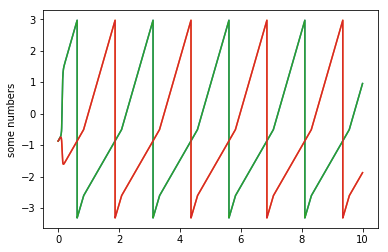

In [12]:
import math
from math import pi, sin, floor
import numpy as np
import matplotlib.pyplot as plt

amp = 1
phase = [0, 0, 0, 0]
f = 0.4
dt = 0.0001
iterations = 100000
time = np.arange(0,iterations * dt, dt)
dr = 0.5
phase_bias = [[0,pi,0,pi],[-pi,0,-pi,0],[0,pi,0,pi],[-pi,0,-pi,0]]
weights = [[0,20,10,20],[20,0,20,10],[10,20,0,20],[20,10,20,0]]
thetlg = -pi / 6
thettg = -5 * pi / 6

def tranop(x):
    if x > pi:
        if (floor(x/pi) % 2 == 1):
            t = (x % (2*pi)) - 2*pi
        else:
            t = (x % (2*pi))

        return t
    return x

# intermediate variables
Sf = (2 * pi - (thetlg - thettg)) / ((1 - dr) * 2 * pi)
Ss = (thetlg - thettg) / (dr * 2 * pi)
thettg_in = tranop(thettg - dr * 2 * pi) + 2*pi # this value needs to be in the interval [-pi, pi], thus add 2pi

def dp(idx):
    phasediff = 2 * pi * f
    for i in range(len(phase)):
        if i != idx:
            phasediff += amp * weights[idx][i] * sin(phase[i] - phase[idx] - phase_bias[idx][i])
    return phasediff
            
def update_values():
    global phase, amp, offset
    for i in range(4):
        phase[i] = phase[i] + dp(i) * dt
            
def output():
    act = []
    for i in range(4):
        if tranop(phase[i]) <= thettg:
            act.append(thettg + (tranop(phase[i]) - thettg) * Sf)
        elif tranop(phase[i]) <= thettg_in:
            act.append(thettg + (tranop(phase[i]) - thettg) * Ss)
        else:
            act.append(thetlg + (tranop(phase[i]) - thettg_in) * Sf)
    
    return act

outputs = []
n1 = []
n2 = []
n3 = []
n4 = []

for i in range(iterations):
    if i < iterations:
        update_values()
        
    result = output()
    n1.append(result[0])
    n2.append(result[1])
    n3.append(result[2])
    n4.append(result[3])

plt.plot(time, n1)
plt.plot(time, n2)
plt.plot(time, n3)
plt.plot(time, n4)
plt.show()

Much as before, but this time a neuron which acts as a dependency for two of the legs. In the salamander robot, this neuron acted as one of the spine components.

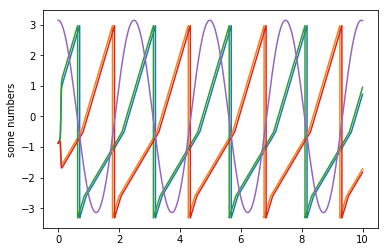

In [13]:
import math
from math import pi, sin, cos, floor
import numpy as np
import matplotlib.pyplot as plt

amp = pi
amp_target = pi
camp = 2
offset = 0
offset_target = 0
coff = 1
phase = [0, 0, 0, 0, 0]
f = 0.4
dt = 0.0001
iterations = 100000
time = np.arange(0,iterations * dt, dt)
dr = 0.5
offset = 0

phase_bias = [[0,pi,0,0,0], [-pi,0,0,0,0], [0,0,0,pi,0], [0,0,-pi,0,0], [0,0,0,0,0]]
weights = [[0,20,10,0,10],[20,0,0,10,10],[10,0,0,20,0],[0,10,20,0,0], [10,10,0,0,0]]

thetlg = -pi / 6
thettg = -5 * pi / 6

def tranop(x):
    if x > pi:
        if (floor(x/pi) % 2 == 1):
            t = (x % (2*pi)) - 2*pi
        else:
            t = (x % (2*pi))

        return t
    return x


# intermediate variables
Sf = (2 * pi - (thetlg - thettg)) / ((1 - dr) * 2 * pi)
Ss = (thetlg - thettg) / (dr * 2 * pi)
thettg_in = tranop(thettg - dr * 2 * pi) + 2*pi

def da():
    return camp * (amp_target - amp)

def do():
    return coff * (offset_target - offset)

def dp(idx):
    phasediff = 2 * pi * f
    for i in range(len(phase)):
        if i != idx:
            phasediff += amp * weights[idx][i] * sin(phase[i] - phase[idx] - phase_bias[idx][i])
    return phasediff
            
def update_values():
    global amp, offset
    for i in range(len(phase)):
        phase[i] = phase[i] + dp(i) * dt
    amp = amp + da() * dt
    offset = offset + do() * dt
    
def output():
    act = []
    for i in range(5):
        if i == 4:
            act.append(amp * cos(phase[i]) + offset)
        elif tranop(phase[i]) <= thettg:
            act.append(thettg + (tranop(phase[i]) - thettg) * Sf)
        elif tranop(phase[i]) <= thettg_in:
            act.append(thettg + (tranop(phase[i]) - thettg) * Ss)
        else:
            act.append(thetlg + (tranop(phase[i]) - thettg_in) * Sf)
    
    return act

outputs = []
n1 = []
n2 = []
n3 = []
n4 = []
n5 = []

for i in range(iterations):
    if i < iterations:
        update_values()
        
    result = output()
    n1.append(result[0])
    n2.append(result[1])
    n3.append(result[2])
    n4.append(result[3])
    n5.append(result[4])
    
plt.plot(time, n1)
plt.plot(time, n2)
plt.plot(time, n3)
plt.plot(time, n4)
plt.plot(time, n5)
plt.show()